                            OLS Regression Results                            
Dep. Variable:            log_rentals   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     792.2
Date:                Sat, 10 May 2025   Prob (F-statistic):               0.00
Time:                        15:30:17   Log-Likelihood:                -7656.8
No. Observations:                8465   AIC:                         1.537e+04
Df Residuals:                    8435   BIC:                         1.558e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.5049 

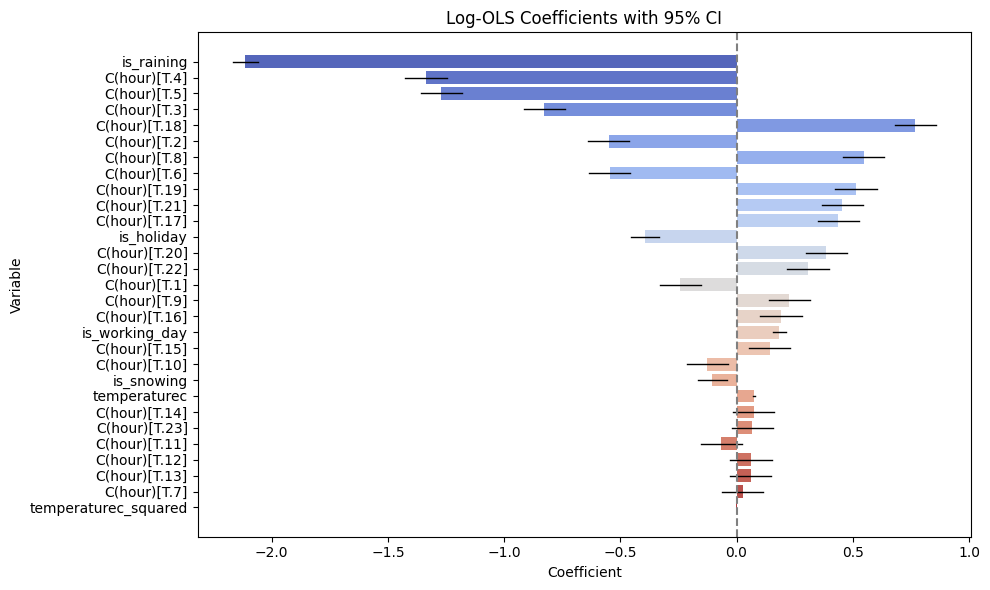

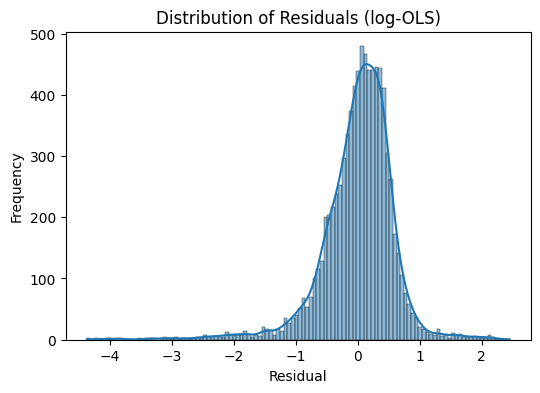

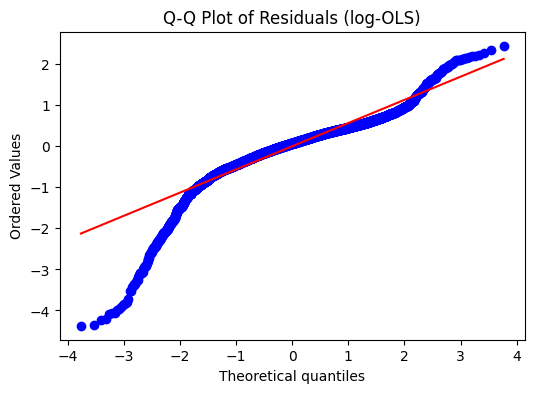

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np 

# === Step 1: Load and filter ===
df = pd.read_csv("SeoulBikeDataClean.csv")
df = df[df['functioning_day'] == 'Yes'].copy()
df['log_rentals'] = np.log1p(df['rented_bike_count'])  # log1p avoids log(0)

# === Step 2: 定义模型公式 ===
formula = (
    'log_rentals ~ temperaturec + temperaturec_squared + '
    'is_raining + is_snowing + is_holiday + is_working_day + '
    'C(hour)'
)

# === Step 3: 拟合模型 ===
model = smf.ols(formula=formula, data=df).fit()
print(model.summary())

# === Step 4: VIF 检查 ===
X = model.model.exog
vif_df = pd.DataFrame({
    "Variable": model.model.exog_names,
    "VIF": [variance_inflation_factor(X, i) for i in range(X.shape[1])]
})
print("\nVariance Inflation Factors (VIF):")
print(vif_df.sort_values(by="VIF", ascending=False))

# === Step 5: 系数图（含置信区间）===
coef_df = model.summary2().tables[1].reset_index()
coef_df.columns = ['variable', 'coef', 'std_err', 't', 'P>|t|', '[0.025', '0.975]']
coef_df = coef_df[coef_df['variable'] != 'Intercept']
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values(by='abs_coef', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=coef_df,
    y='variable', x='coef',
    orient='h',
    palette='coolwarm',
    errorbar=None
)
for i, row in enumerate(coef_df.itertuples()):
    plt.plot([row._6, row._7], [i, i], color='black', lw=1)

plt.axvline(0, color='grey', linestyle='--')
plt.title("Log-OLS Coefficients with 95% CI")
plt.xlabel("Coefficient")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

# === Step 6: 残差分析 ===
residuals = model.resid

# Histogram
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (log-OLS)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (log-OLS)")
plt.show()
